In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from get_modules.get_loaders import get_loaders
from get_modules.get_models import get_models
from get_modules.get_trainers import get_trainers
from utils import get_optimizers, get_crits, recorder, visualizer
from scipy.special import softmax


device = "cuda" if torch.cuda.is_available() else "cpu"

# load model ...
model_dict = torch.load("../param/0.8496578183801722_monaconvbert_2009.pth", map_location=device)
print(model_dict)
setattr(model_dict['config'], 'fivefold', False)
config = model_dict['config']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, valid_loader, test_loader, num_q, num_r, num_pid, num_diff = get_loaders(config)
del train_loader
del valid_loader
# gc.collect()​
# torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

# 2. select models using get_models
model = get_models(num_q, num_r, num_pid, num_diff, device, config)
# 3. select optimizers using get_optimizers
optimizer = get_optimizers(model, config)
# 4. select crits using get_crits
crit = get_crits(config)

model.load_state_dict(model_dict['model'])

# 5. select trainers for models, using get_trainers
trainer = get_trainers(model, optimizer, device, num_q, crit, config)
# 6. use trainer.train to train the models
if config.crit == "binary_cross_entropy":
    best_test_score = 0
    metric_name = "AUC"
elif config.crit == "rmse":
    best_test_score = float('inf')
    metric_name = "RMSE"

# train test_loader
test_score = trainer._test(test_loader, metric_name)
if config.crit == "binary_cross_entropy":
    if test_score >= best_test_score:
        best_test_score = test_score
elif config.crit == "rmse":
    if test_score <= best_test_score:
        best_test_score = test_score

print("result: test_score=%.4f best_test_score=%.4f" % (
    test_score,
    best_test_score,
))

In [ ]:
epoch = 0
attnviz_df = pd.DataFrame(columns=range(149),index=range(149))

for data in test_loader : #epoch
    for bs in range(len(data[epoch])) : # batch size
        if data[epoch][bs].max() > 148 : continue
        if data[epoch][bs].dtype == torch.bool : continue
            # data[epoch][bs] = torch.gt(data[epoch][bs], 0).float()
        seq  = data[epoch][bs].tolist()

        for head_num in range(8) :
            if head_num==0 : head_avg = model.encoder[11].attn_scores[epoch][bs][head_num]
            else : head_avg = torch.add(model.encoder[11].attn_scores[epoch][bs][head_num],head_avg)
        # print(torch.sum(head_avg,axis=1))
        head_avg = head_avg.div(8)

        avgattn_df = pd.DataFrame(head_avg.numpy(), index=seq , columns=seq).transpose()
        # print(avgattn_df)
        drop_idx = avgattn_df[avgattn_df.sum(axis=1)==0].index
        avgattn_df.drop(index=drop_idx,inplace=True)
        avgattn_df = avgattn_df.transpose()
        avgattn_df.drop(index=drop_idx,inplace=True)
        avgattn_df = avgattn_df.transpose()

        # if data[epoch][bs].min() == 0 : avgattn_df.drop(index=0,columns=0,inplace=True)
        
        temp_df = pd.DataFrame()
        for col_name in list(set(avgattn_df.columns.to_list())) :
            if len(avgattn_df[col_name].shape) > 1 : temp_df[col_name] = avgattn_df[col_name].sum(axis=1).div(avgattn_df[col_name].shape[1])
            else : temp_df[col_name] = avgattn_df[col_name]

        temp_df = temp_df.transpose()
        result_df = pd.DataFrame()
        for col_name in list(set(temp_df.columns.to_list())) :
            if len(temp_df[col_name].shape) > 1 : result_df[col_name] = temp_df[col_name].sum(axis=1).div(temp_df[col_name].shape[1])
            else : result_df[col_name] = temp_df[col_name]

        result_np = result_df.to_numpy()
        if (result_np.size > 0) : 
            result_softmax = softmax(result_np,axis=1)
            softmax_df = pd.DataFrame(result_softmax,index=result_df.index,columns=result_df.columns.values)
            
            for col in softmax_df.columns :
                for idx in softmax_df.index :
                    if np.isnan(attnviz_df[col][idx]) : attnviz_df[col][idx] = softmax_df[col][idx]
                    else : 
                        attnviz_df[col][idx] = (softmax_df[col][idx] + attnviz_df[col][idx]) / 2       
        
    epoch += 1

# visualization
attnviz_df = attnviz_df.fillna(0)
attnviz_df.to_csv("attn_result.csv")

In [ ]:
attnviz_df

0         1         2         3         4         5         6    \
0    0.497239  0.502761  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.497776  1.000000  0.037171  0.000000  0.000000  0.070785  0.112334   
2    0.000000  0.036858  0.050059  0.050798  0.047383  0.036746  0.000000   
3    0.000000  0.000000  0.050321  0.078242  0.062621  0.040995  0.067444   
4    0.000000  0.000000  0.046413  0.062944  0.019483  0.033227  0.027589   
..        ...       ...       ...       ...       ...       ...       ...   
144  0.000000  0.000000  0.035449  0.068561  0.048356  0.035562  0.041511   
145  0.000000  0.000000  0.049466  0.000000  0.000000  0.000000  0.000000   
146  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147  0.000000  0.000000  0.041685  0.036071  0.035316  0.036177  0.000000   
148  0.000000  0.000000  0.039507  0.036079  0.031508  0.036184  0.000000   

          7         8         9    ...       139       140       141  \
0    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3    0.084322  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4    0.035836  0.021077  0.028715  ...  0.000000  0.027556  0.043982   
..        ...       ...       ...  ...       ...       ...       ...   
144  0.041342  0.000000  0.038207  ...  0.041575  0.034793  0.034277   
145  0.038676  0.000000  0.000000  ...  0.000000  0.000000  0.038329   
146  0.043354  0.000000  0.000000  ...  0.041345  0.041558  0.041424   
147  0.053849  0.028971  0.028991  ...  0.050504  0.045454  0.037344   
148  0.053677  0.028964  0.028983  ...  0.057892  0.036739  0.035679   

          142       143       144       145       146       147       148  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    0.067517  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2    0.000000  0.000000  0.035468  0.049425  0.000000  0.042463  0.039959  
3    0.099198  0.000000  0.069409  0.000000  0.000000  0.036063  0.036066  
4    0.063339  0.000000  0.048805  0.000000  0.000000  0.035286  0.031603  
..        ...       ...       ...       ...       ...       ...       ...  
144  0.082003  0.041331  0.120880  0.000000  0.041510  0.038964  0.031938  
145  0.038601  0.000000  0.000000  0.043770  0.000000  0.051276  0.051242  
146  0.041456  0.041518  0.041583  0.000000  0.059514  0.049488  0.044954  
147  0.034956  0.042256  0.038814  0.050181  0.049571  0.269134  0.298624  
148  0.034598  0.040833  0.032160  0.050199  0.045303  0.281012  0.294656  

[149 rows x 149 columns]

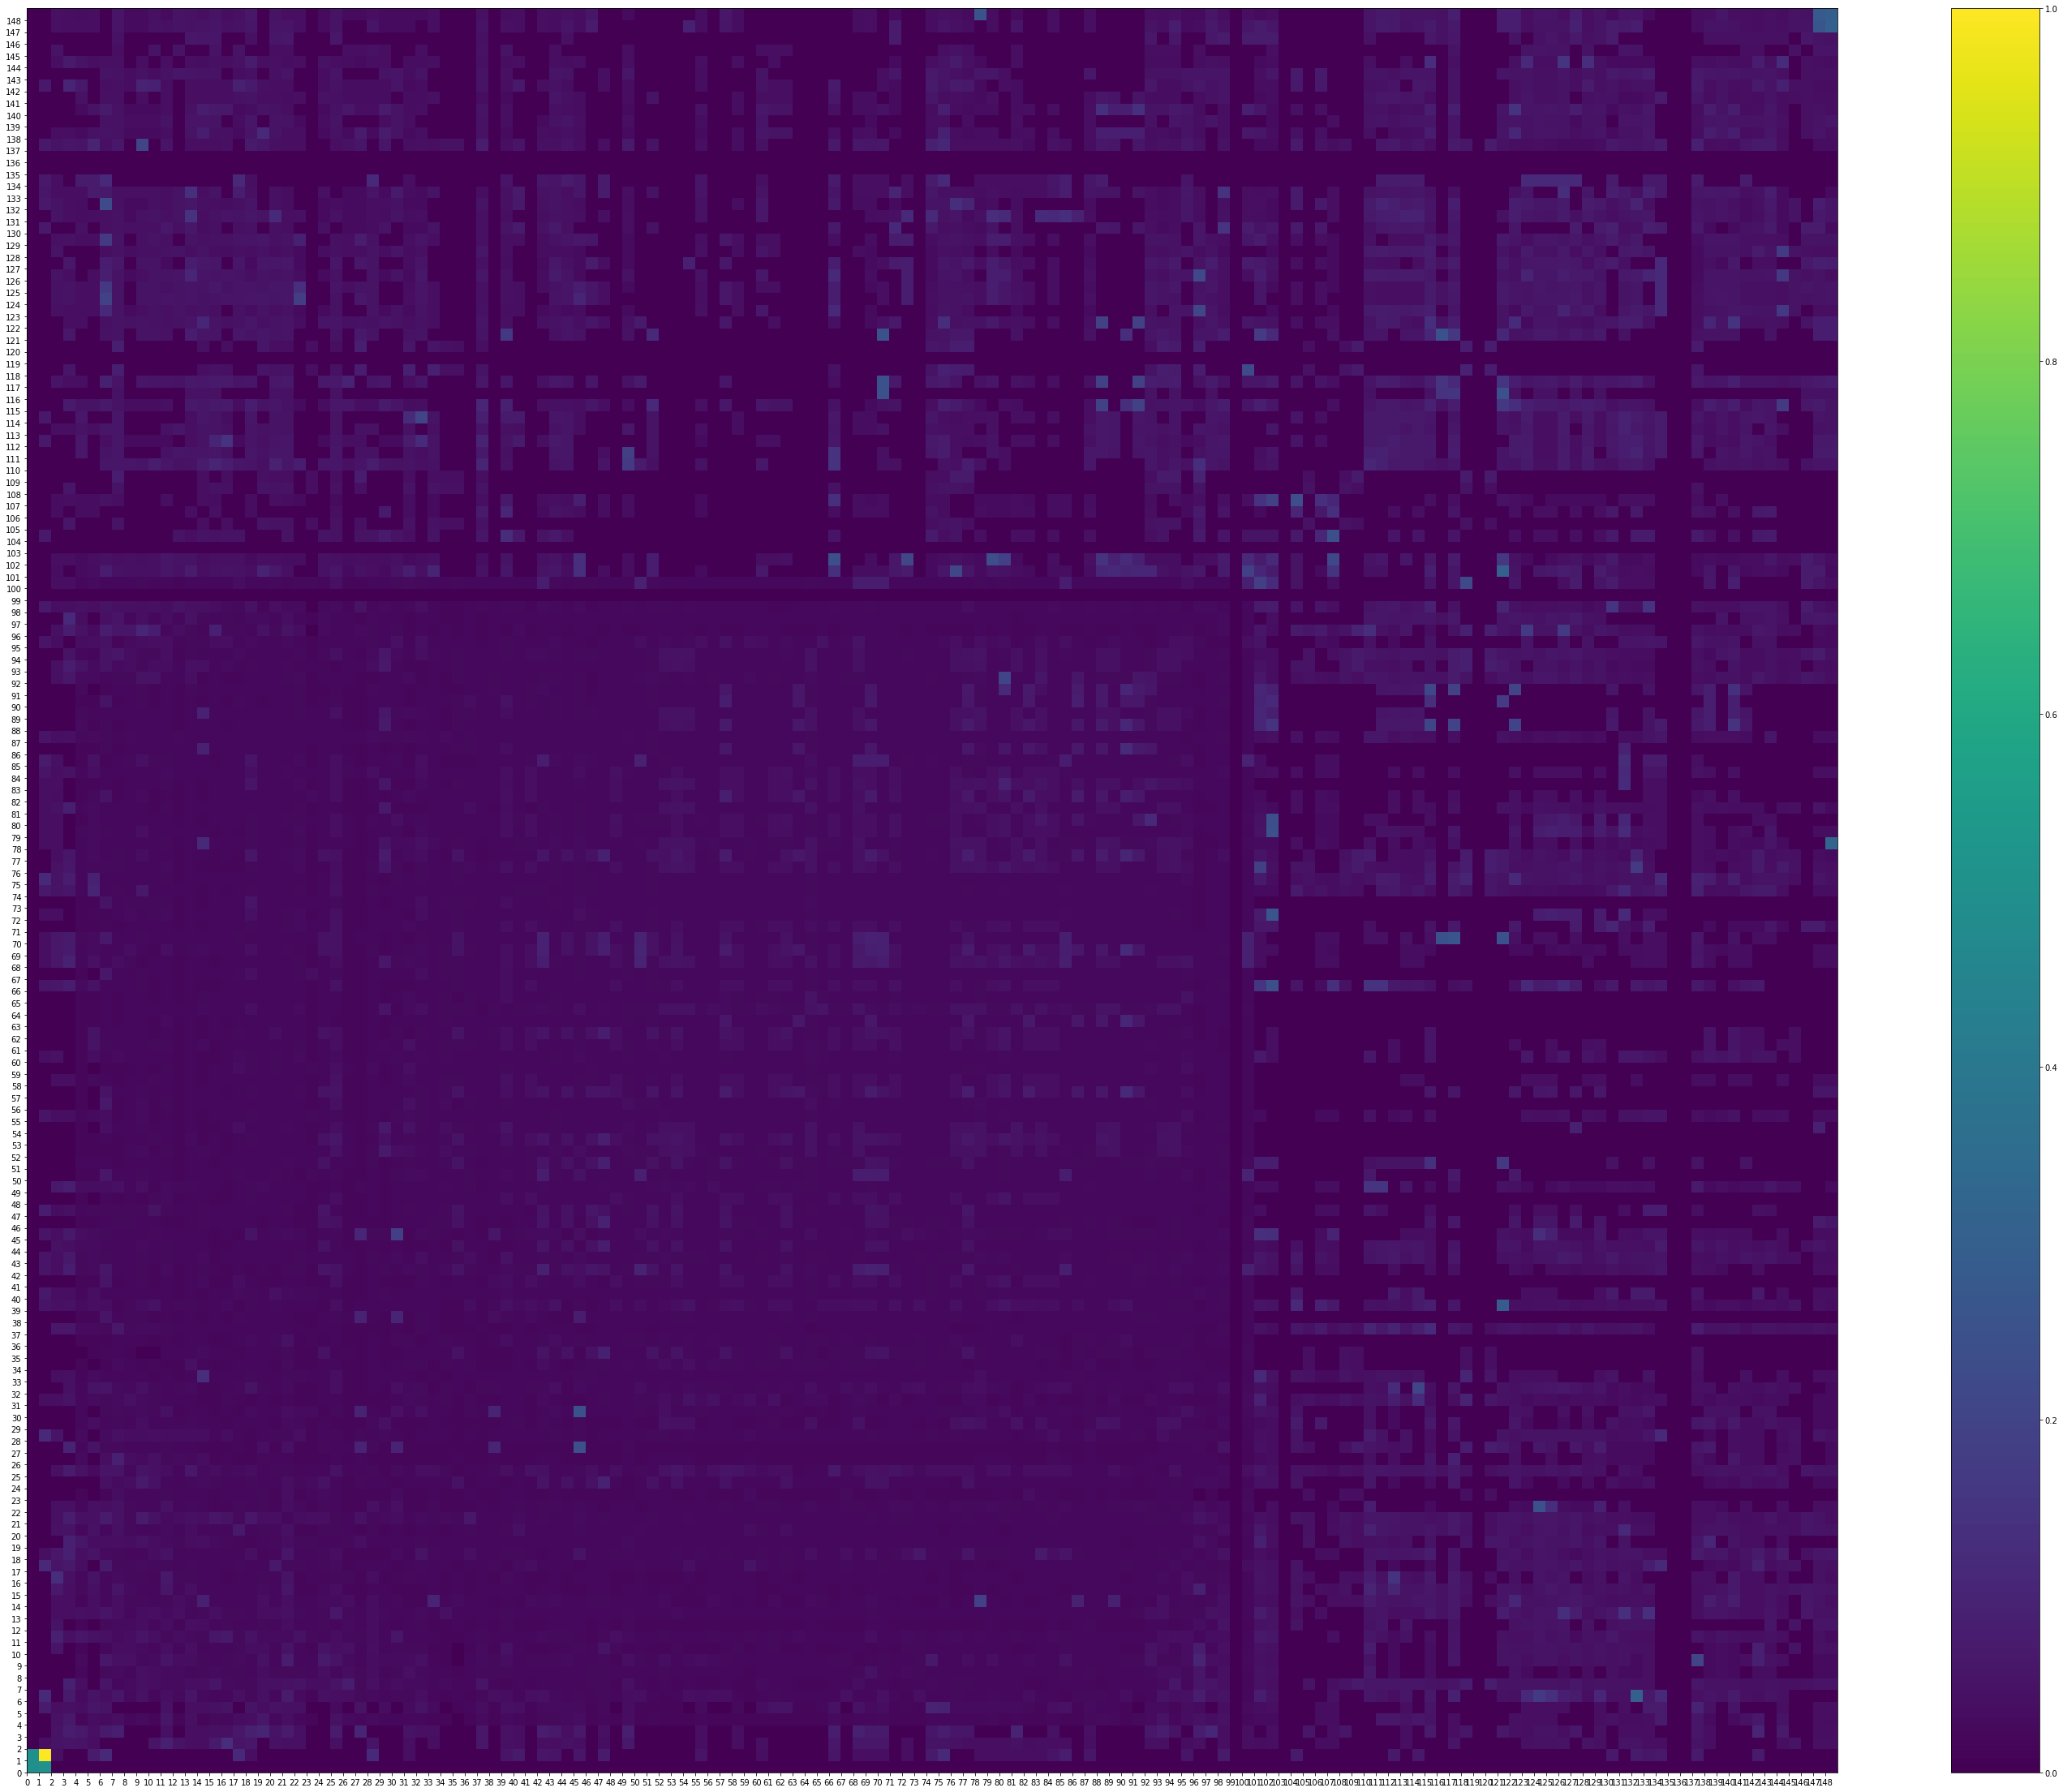

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50,40))
fig.set_facecolor('white')
 
plt.pcolor(attnviz_df.values)
plt.xticks(range(len(attnviz_df.columns)),attnviz_df.columns) ## x축 눈금 생성
plt.yticks(range(len(attnviz_df.index)), attnviz_df.index) ## y축 눈금 생성
plt.xticks(rotation=60)

plt.colorbar()
plt.show()
plt.savefig('heatmap_with_monotonicattn.png')

In [ ]:
attnviz_df = pd.read_csv("attn_result.csv")
attnviz_df.drop(columns='Unnamed: 0',inplace=True);attnviz_df

In [ ]:
add_list = []
for col_name in attnviz_df.columns.to_list() :
    for idx in attnviz_df.index.to_list() :
        if attnviz_df[col_name][idx] > 0.1 :
            add_list.append((idx,int(col_name),attnviz_df[col_name][idx]))
graph_df = pd.DataFrame(add_list, columns = ['source', 'target', 'weight']);graph_df

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(40,30)) 

G = nx.from_pandas_edgelist(graph_df, 'source', 'target', ['weight'], create_using = nx.DiGraph)
# G = nx.from_pandas_adjacency(graph_df)
# nx.draw(G, with_labels=True)
# nx.draw(G, pos=nx.spring_layout(G))  
# plt.draw()

# seed = 13648  # Seed random number generators for reproducibility
pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G,seed=seed)
M = G.number_of_edges()
edge_colors = graph_df['weight']
# edge_colors = range(2, M + 2)
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.viridis

nodes = nx.draw_networkx_nodes(G, pos, node_size = 3000, node_color="mediumpurple")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size = 3000,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=graph_df['weight']*15,
)
nx.draw_networkx_labels(G, pos, font_size=30)

# # set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [ ]:
# plt.show()
plt.savefig('graph_with_monotonicattn.png')

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

attnviz_df['149'] = np.nan
attn_15 = attnviz_df.iloc[[15],110:120]
attn_112 = attnviz_df.iloc[[112],10:20]
attn_144 = attnviz_df.iloc[[144],120:130]
attn_123 = attnviz_df.iloc[[123],140:150]
attn_126 = attnviz_df.iloc[[126],140:150]
attn_128 = attnviz_df.iloc[[128],140:150]

fig, ax = plt.subplots(figsize=(45, 30), nrows=6)
cbar_ax = fig.add_axes([.91, .3, .01, .4])
cmap = sns.diverging_palette(220, 20, as_cmap=True)

vmin = 0
vmax = 0.18
sns.heatmap(attn_15, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[0], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
sns.heatmap(attn_112, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[1], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_144, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[2], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_123, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[3], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_126, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[4], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_128, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[5], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)